In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import cv_color_features.utils as color_utils
import cv2_extras as cv2x

%matplotlib inline

In [3]:
fig_size = (12, 12)

data_parent_dir = '/home/swhite/git/ihc-segmentation-testing'
data_sub_dir = 'tmp/mm_e16.5_20x_sox9_sftpc_acta2/light_color_corrected_SVMPipeline'
img_file = "2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001_residual.tif"
img_file_path = os.path.join(data_parent_dir, data_sub_dir, img_file)
cnt_mask_path = img_file_path.replace('_residual.tif', '_mask.npy')

contour_mask = np.load(cnt_mask_path)

img = cv2.imread(img_file_path)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
img_s = img_hsv[:, :, 1]

img_shape = (img.shape[0], img.shape[1])

In [4]:
large_blur_kernel = (95, 95)
med_blur_kernel = (63, 63)
small_blur_kernel = (31, 31)

cross_strel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

ellipse_strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
ellipse90_strel = np.rot90(ellipse_strel)

circle_strel = np.bitwise_or(ellipse_strel, ellipse90_strel)

### Pre-processing

Instead of removing the "blue" pixels, just remove the blue from ALL the pixels. This essentially enhances any edges without any blurring or magic numbers.

In [5]:
b_over_r = img_rgb[:, :, 0] < img_rgb[:, :, 2]
b_over_g = img_rgb[:, :, 1] < img_rgb[:, :, 2]

b_over_rg = np.bitwise_and(b_over_r, b_over_g)

b_replace = np.max([img_rgb[:, :, 0], img_rgb[:, :, 1]], axis=0)

b_suppress_img = img_rgb.copy()
b_suppress_img[b_over_rg, 2] = b_replace[b_over_rg]
b_suppress_img_hsv = cv2.cvtColor(b_suppress_img, cv2.COLOR_RGB2HSV)

enhanced_v_img = b_suppress_img_hsv[:, :, 2]
enhanced_s_img = b_suppress_img_hsv[:, :, 1]

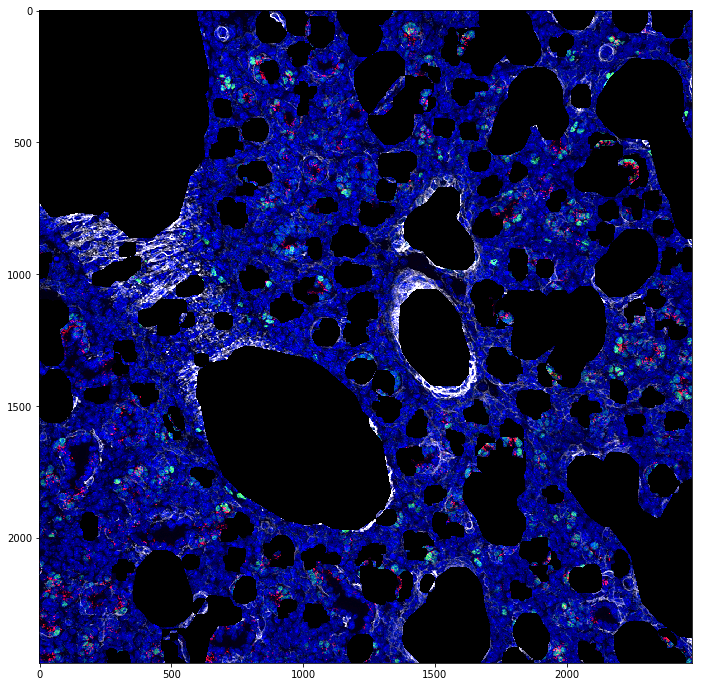

In [6]:
fig = plt.figure(figsize=fig_size)
plt.imshow(img_rgb)

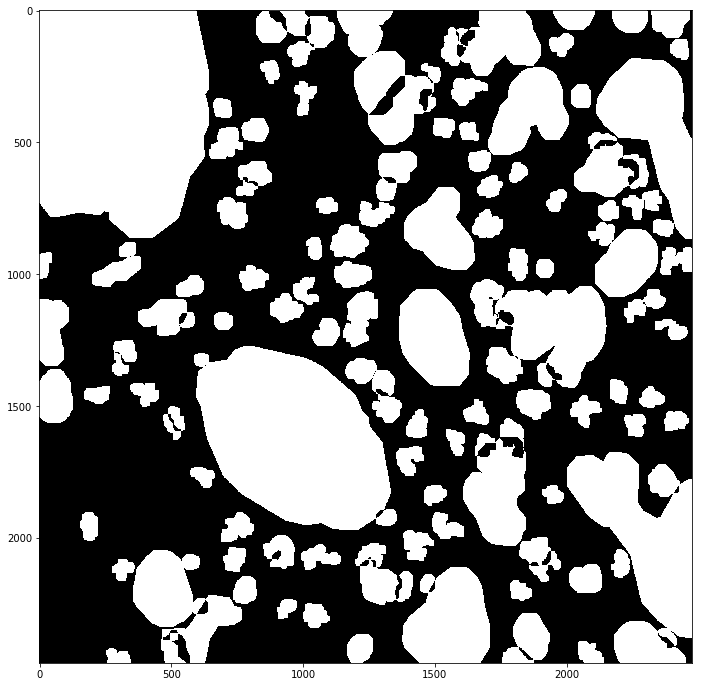

In [7]:
fig = plt.figure(figsize=fig_size)
plt.imshow(contour_mask, cmap='gray')

In [8]:
inv_masked_img_s = cv2.bitwise_and(~img_s, ~img_s, mask=~contour_mask)
masked_enhanced_img_s = cv2.bitwise_and(enhanced_s_img, enhanced_s_img, mask=~contour_mask)

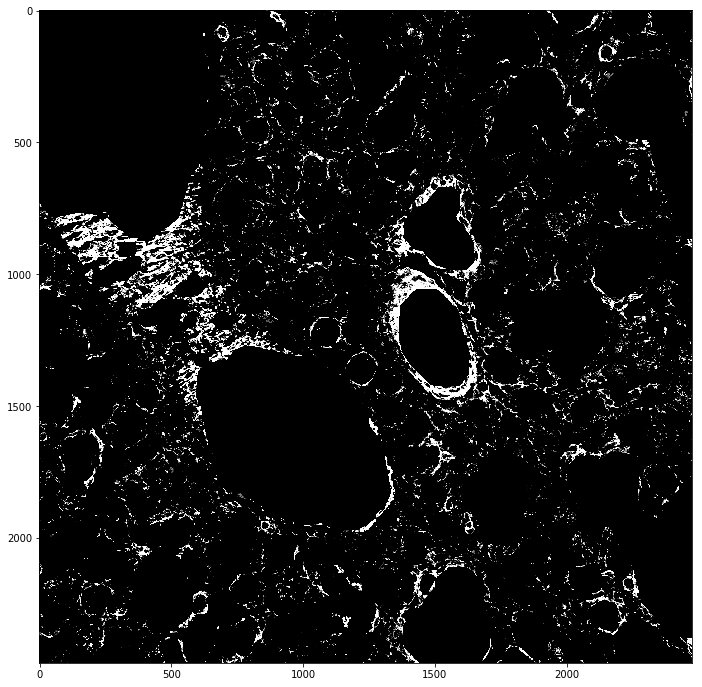

In [19]:
fig = plt.figure(figsize=fig_size)
plt.imshow(inv_masked_img_s, cmap='gray', vmin=63, vmax=127)

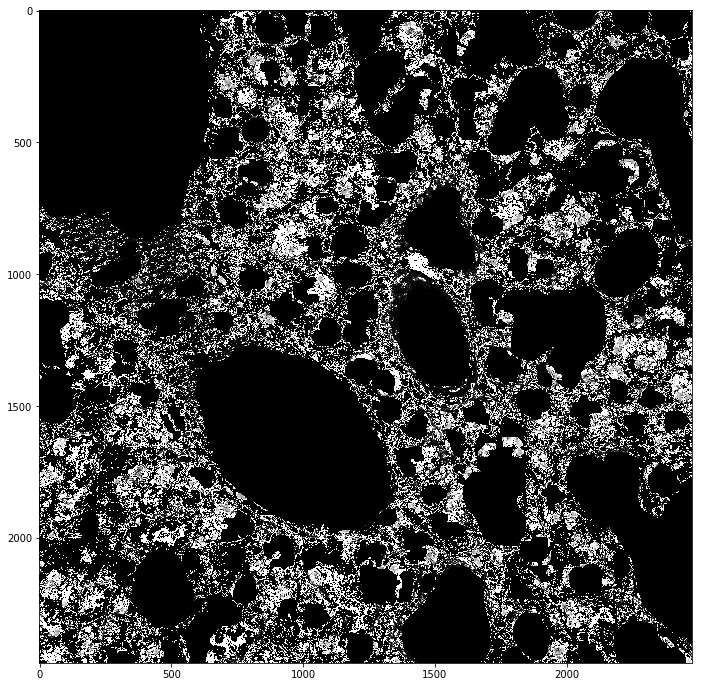

In [10]:
fig = plt.figure(figsize=fig_size)
plt.imshow(masked_enhanced_img_s, cmap='gray')

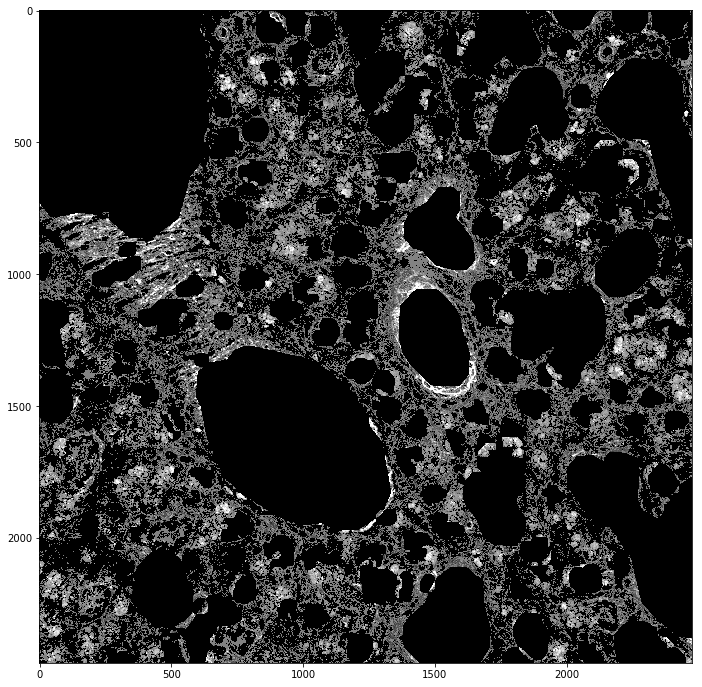

In [12]:
fig = plt.figure(figsize=fig_size)
plt.imshow(
    (np.sum([masked_enhanced_img_s, enhanced_v_img, inv_masked_img_s], axis=0)), 
    cmap='gray'
)

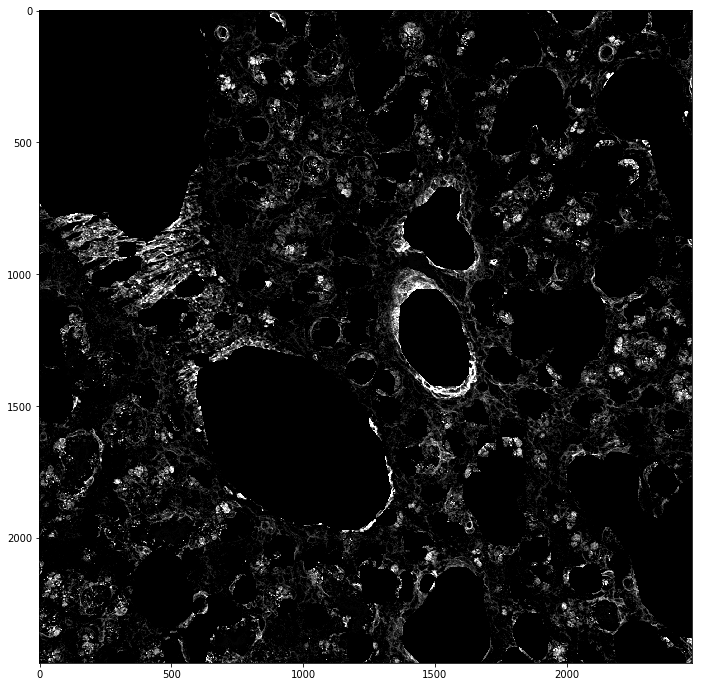

In [8]:
fig = plt.figure(figsize=fig_size)
plt.imshow(enhanced_v_img, cmap='gray', vmin=0, vmax=255)

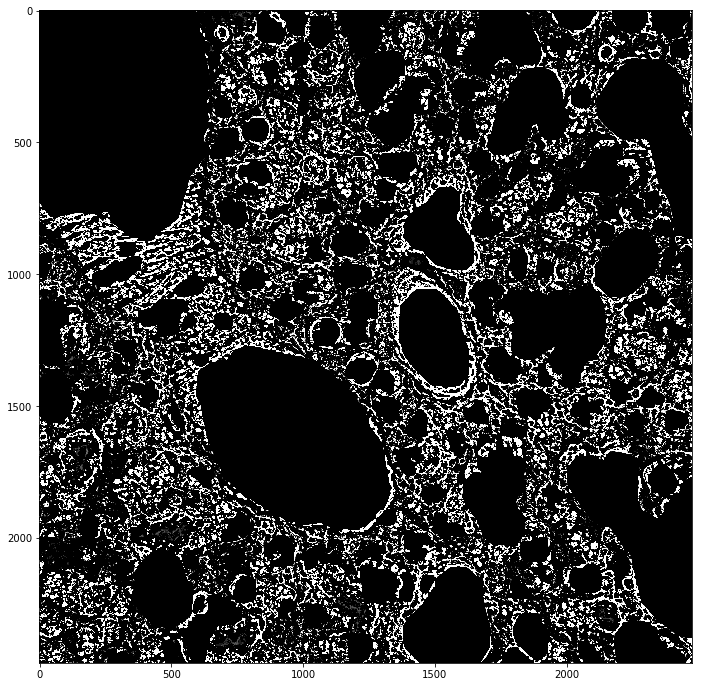

In [88]:
# diff of gaussians
img_blur_1 = cv2.blur(enhanced_v_img, (3, 3))
img_blur_2 = cv2.blur(enhanced_v_img, (31, 31))

tmp_img_1 = img_blur_1.astype(np.int16)
tmp_img_2 = img_blur_2.astype(np.int16)

edge_mask = tmp_img_1 - tmp_img_2

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray', vmin=0, vmax=9)

In [ ]:
edge_mask[edge_mask > 0] = 0
edge_mask[edge_mask < 0] = 255

edge_mask = edge_mask.astype(np.uint8)

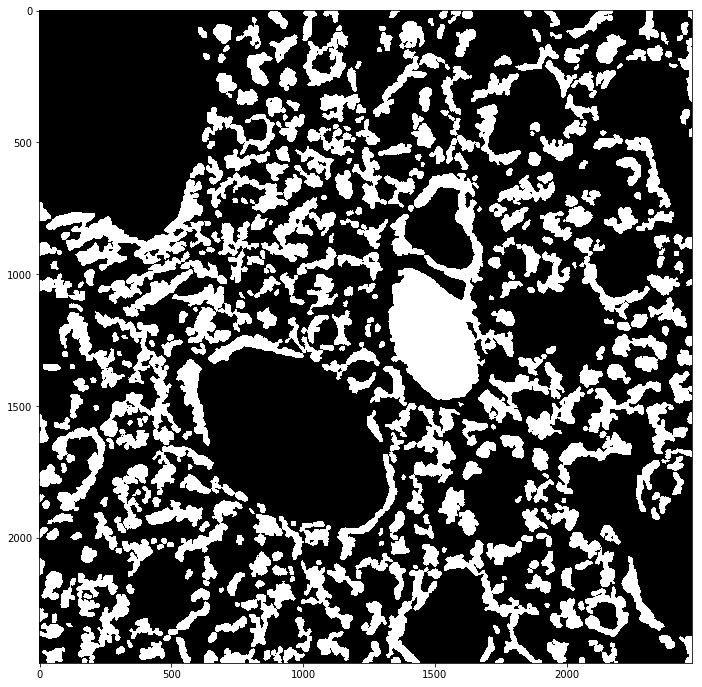

In [10]:
contours = cv2x.filter_contours_by_size(edge_mask, min_size=15*15)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, cross_strel, iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

### Color candidates

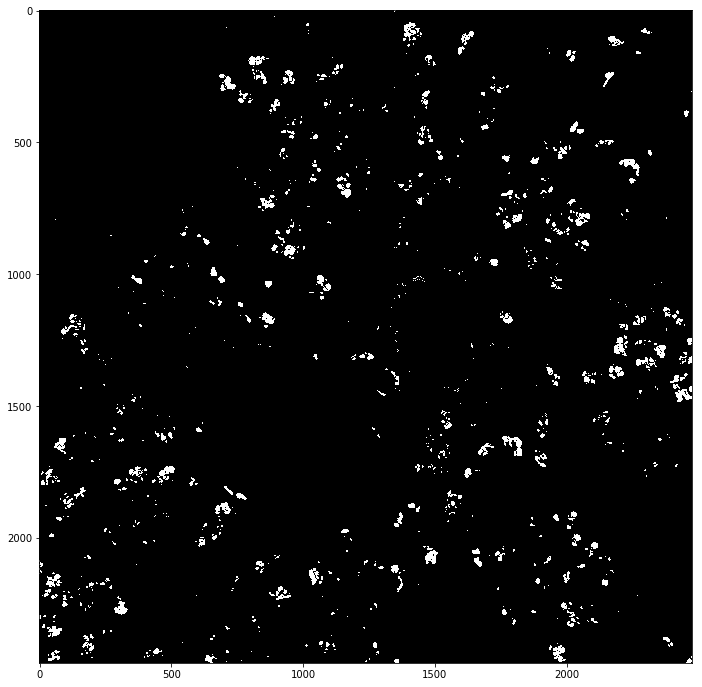

In [11]:
# blur the blue suppressed image just slightly to connect 
# adjacent cells of the same structure
tmp_color_img = cv2.cvtColor(b_suppress_img_hsv, cv2.COLOR_HSV2RGB)
tmp_color_img = cv2.blur(tmp_color_img, (9, 9))
tmp_color_img = cv2.cvtColor(tmp_color_img, cv2.COLOR_RGB2HSV)

color_mask = color_utils.create_mask(
    tmp_color_img,
    [
        'green', 'cyan', 'red', 'violet', 'yellow'
    ]
)

color_mask = cv2.bitwise_and(color_mask, color_mask, mask=edge_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(color_mask, cmap='gray')

In [13]:
# Next, clean up any "noise", say, ~ 5 x 5
contours = cv2x.filter_contours_by_size(color_mask, min_size=5*5)

color_mask2 = np.zeros(img_shape, dtype=np.uint8)
color_mask2 = cv2.drawContours(color_mask2, contours, -1, 255, -1)

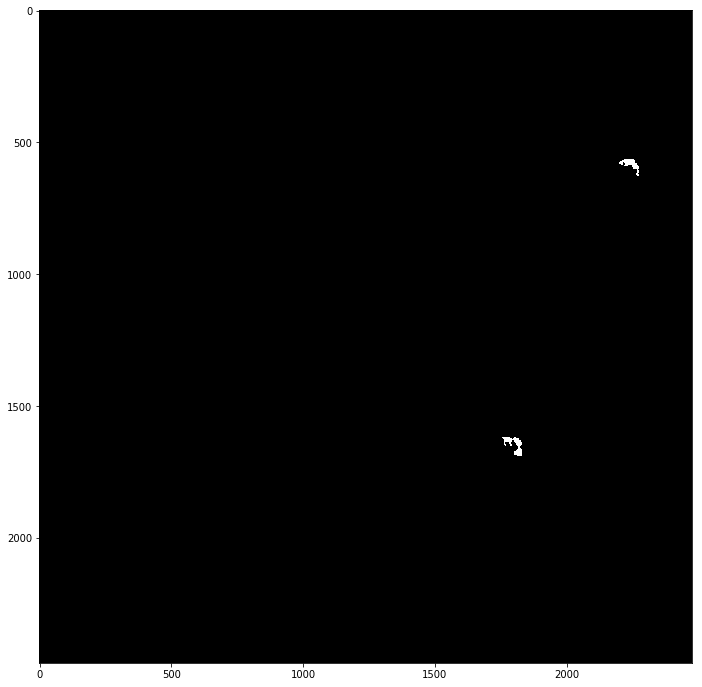

In [14]:
# do a couple dilations to smooth some outside edges & connect any adjacent cells each other
color_mask3 = cv2.dilate(color_mask2, cross_strel, iterations=2)

# do a couple dilations to smooth some outside edges & connect any adjacent cells each other
color_mask3 = cv2.erode(color_mask3, cross_strel, iterations=3)

# filter out any remaining contours that are the size of roughly 2 cells
contours = cv2x.filter_contours_by_size(color_mask3, min_size=2*40*40)

color_mask3 = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(color_mask3, contours, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(color_mask3, cmap='gray')

In [15]:
len(contours)

2

In [17]:
good_color_contours = []

for i, c in enumerate(contours):
    print('#', i, '#')
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = cv2x.find_border_by_mask(
        edge_mask, 
        filled_c_mask, 
        max_dilate_percentage=0.3,
        dilate_iterations=1
    )
    
    print('\t', signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        good_color_contours.append(contours[0])
    elif orig and signal > 0.7:
        good_color_contours.append(c)
    else:
        pass  # don't include contour

# 0 #
	 1.0
# 1 #
	 1.0


In [18]:
len(good_color_contours)

2

In [19]:
# The previous contours represent the final count of contours for the color group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next 2 groups of candidates
final_color_contours = []

for c in good_color_contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.007 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.erode(single_cnt_mask, np.ones((3, 3)), iterations=1)
    single_cnt_mask = cv2.dilate(single_cnt_mask, np.ones((3, 3)), iterations=8)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    if len(tmp_contours) > 0:
        final_color_contours.append(tmp_contours[0])

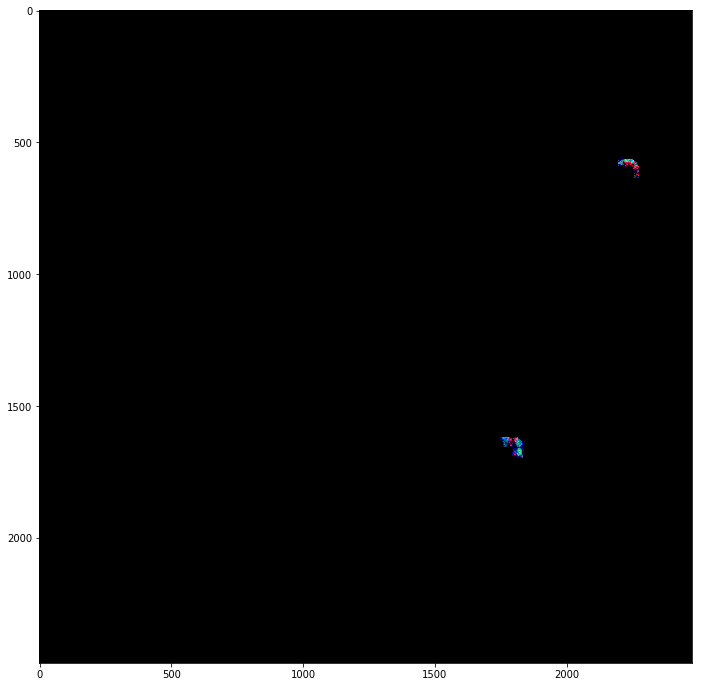

In [20]:
# final color mask to use for exclusion from further groups
final_color_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_color_mask, final_color_contours, -1, 255, -1)

final_color_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_color_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(final_color_img)

### The broken border problem

The fact is, border markers (usu. muscle?) are typically either broken (larger structures) or quite thin (smaller structures). This poses a problem for any thresholding based segmentation approach. Applying any blurring techniques involves choosing arbitrary kernel sizes. Any dilation approach, even "smart" techniques of extending eccentric contours or bridging using custom convolution kernels also requires arbitrary choices and inevitably bridges some adjacent structures together.

What can be found is the center regions via saturation, which can then be dilated by a simple 3x3 kernel one iteration at a time to measure the border intensity of this expanding ring. Regardless of whether a border is broken or thin, this will still yield a closed structure.

#### Large sat-val candidates

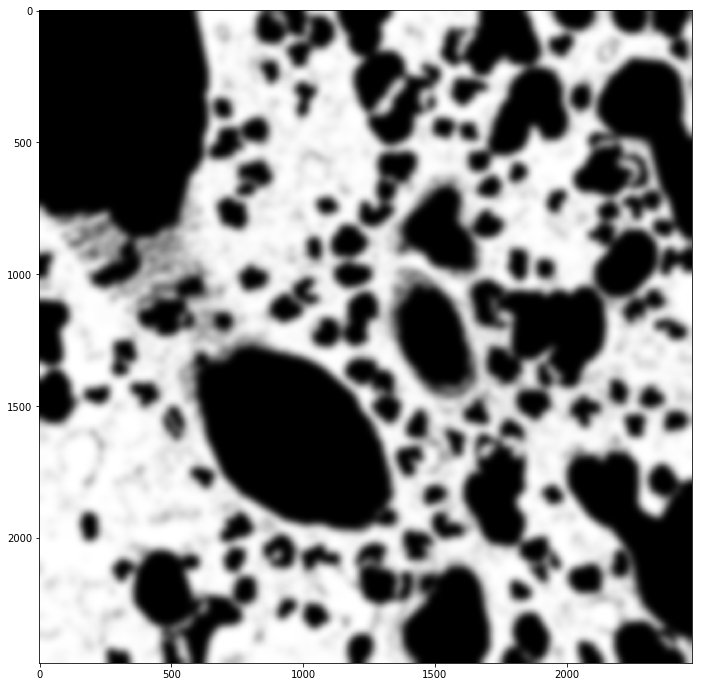

In [21]:
# start large structure saturation candidates
img_s_large_blur = cv2.GaussianBlur(img_s, large_blur_kernel, 0, 0)

fig = plt.figure(figsize=fig_size)
plt.imshow(img_s_large_blur, cmap='gray')

In [22]:
med = np.median(img_s_large_blur[img_s_large_blur > 0])

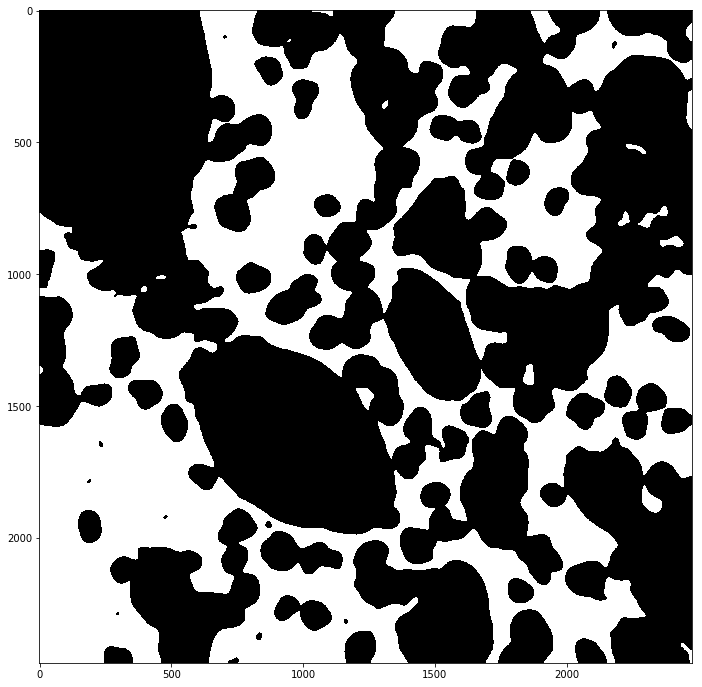

In [23]:
img_s_large_blur = cv2.bitwise_and(img_s_large_blur, img_s_large_blur, mask=~final_color_mask)
mode_s_large = cv2.inRange(img_s_large_blur, med, 255)

fig = plt.figure(figsize=fig_size)
plt.imshow(mode_s_large, cmap='gray')

In [24]:
mode_s_large = cv2.erode(mode_s_large, cross_strel, iterations=5)

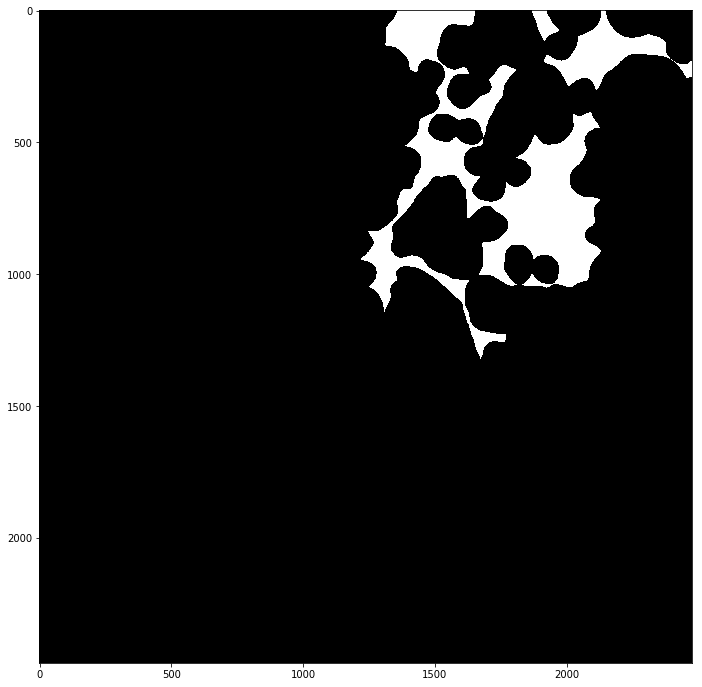

In [26]:
good_contours_large = cv2x.filter_contours_by_size(
    mode_s_large,
    min_size=10 * 32 * 32,
    max_size=(img.shape[0] * img.shape[1]) * .5
)

single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(single_cnt_mask, good_contours_large, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(single_cnt_mask, cmap='gray')

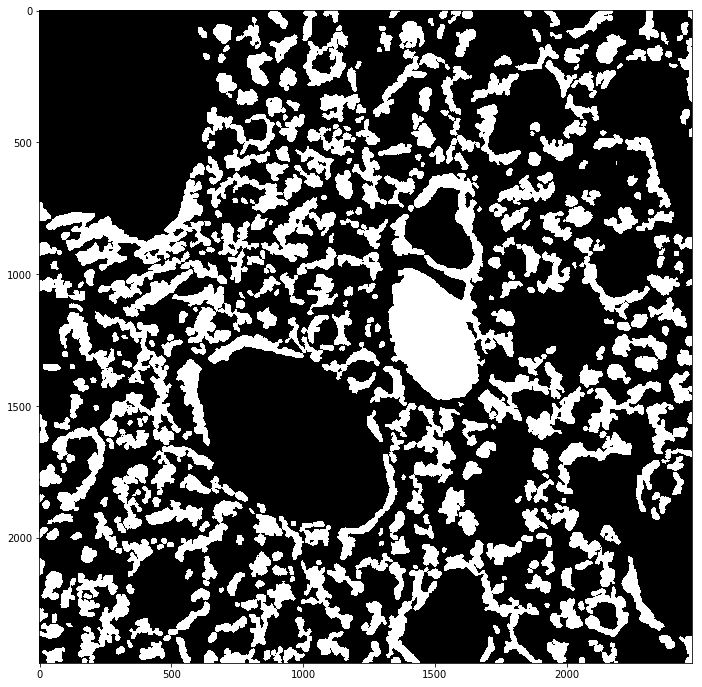

In [27]:
edge_mask = cv2.bitwise_and(edge_mask, edge_mask, mask=~final_color_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray')

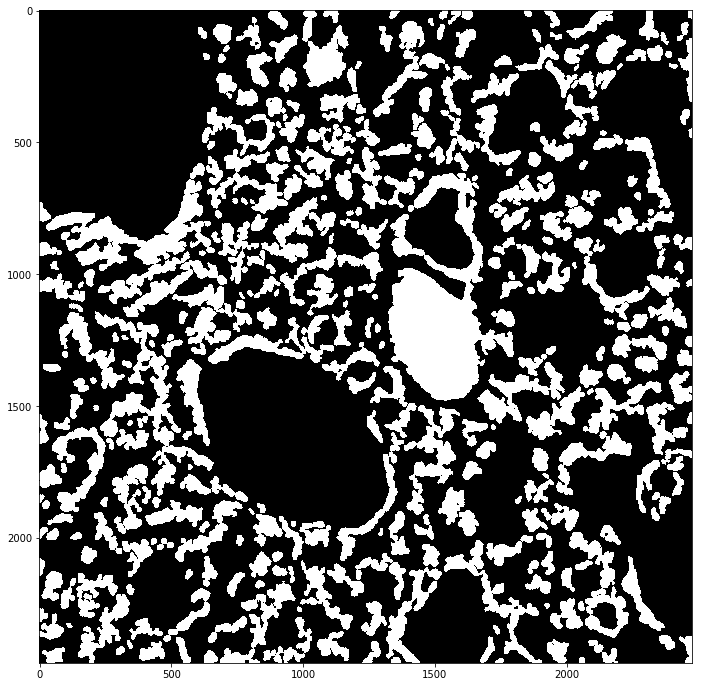

In [29]:
contours = cv2x.filter_contours_by_size(edge_mask, min_size=21*21)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, (3, 3), iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

In [30]:
good_large_sat_val_contours = []

for i, c in enumerate(good_contours_large):
    print('#', i, '#')
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = cv2x.find_border_by_mask(
        edge_mask, 
        filled_c_mask,
        max_dilate_percentage=2.0,
        dilate_iterations=1
    )
    
    print(signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        good_large_sat_val_contours.append(contours[0])
    elif signal > 0.7:
        good_large_sat_val_contours.append(c)
    else:
        pass  # ignore contour

# 0 #
0.7138196915776986
# 1 #
0.5674157303370787
# 2 #
0.5576247901083804


In [31]:
len(good_large_sat_val_contours)

1

In [32]:
# The previous contours represent the final count of contours for the large sat-val group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next group of candidates
final_large_sat_val_contours = []

for c in good_large_sat_val_contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.0035 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.dilate(single_cnt_mask, circle_strel, iterations=10)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    final_large_sat_val_contours.append(tmp_contours[0])

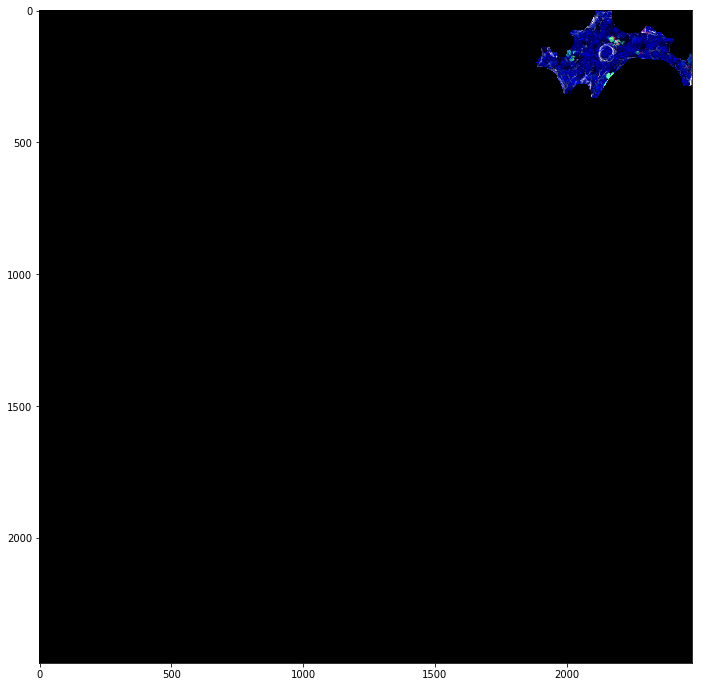

In [33]:
# final color mask to use for exclusion from further groups
final_large_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_large_sat_val_mask, final_large_sat_val_contours, -1, 255, -1)

large_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_large_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(large_sat_val_img)

#### Medium sat-val candidates

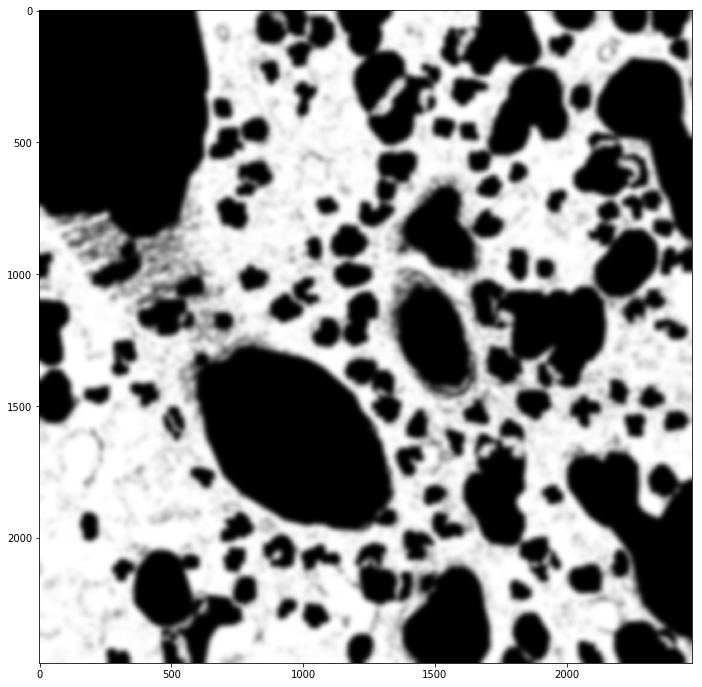

In [34]:
# start medium structure saturation candidates
img_s_medium_blur = cv2.GaussianBlur(img_s, med_blur_kernel, 0, 0)

fig = plt.figure(figsize=fig_size)
plt.imshow(img_s_medium_blur, cmap='gray')

In [35]:
med = np.median(img_s_medium_blur[img_s_medium_blur > 0])

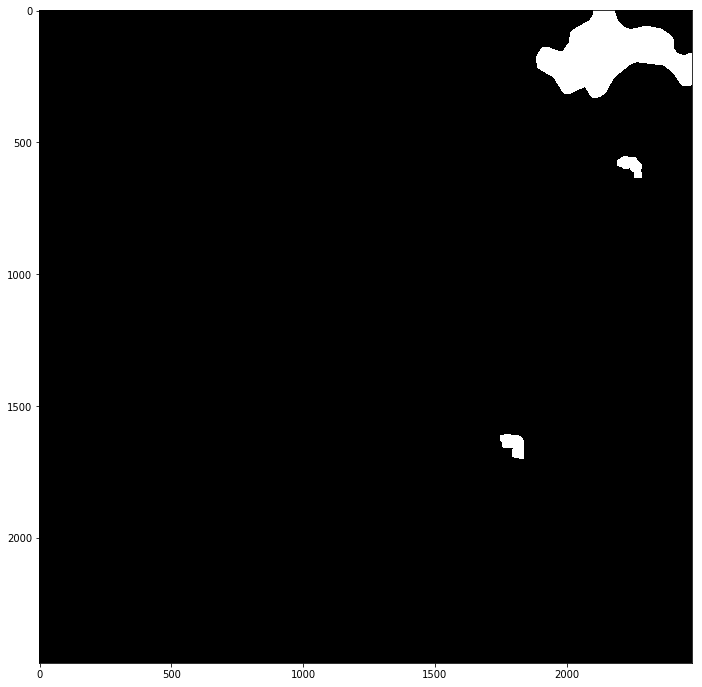

In [36]:
# make intermediate candidate mask
tmp_candidate_mask = np.bitwise_or(final_color_mask, final_large_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_candidate_mask, cmap='gray')

In [37]:
img_s_medium_blur = cv2.bitwise_and(img_s_medium_blur, img_s_medium_blur, mask=~tmp_candidate_mask)

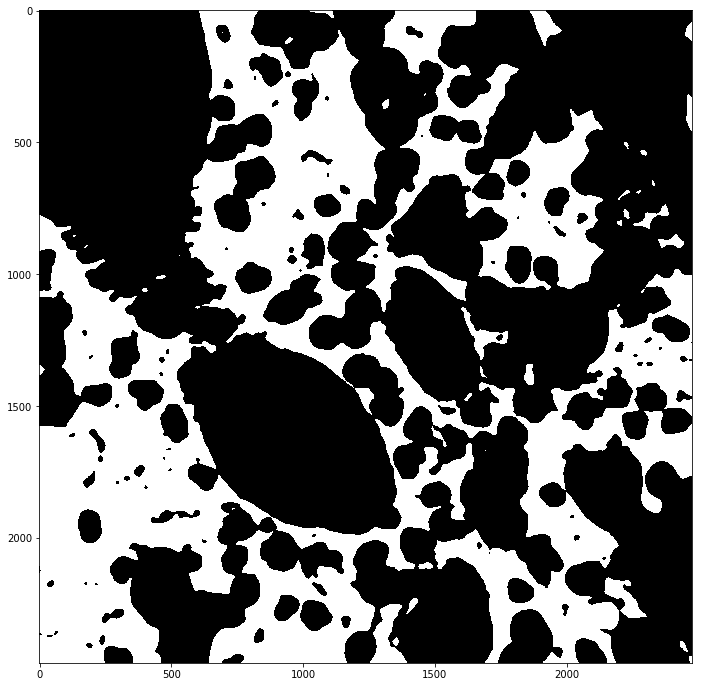

In [38]:
mode_s_med = cv2.inRange(img_s_medium_blur, np.ceil(med), 255)

fig = plt.figure(figsize=fig_size)
plt.imshow(mode_s_med, cmap='gray')

In [39]:
mode_s_med = cv2.erode(mode_s_med, cross_strel, iterations=8)

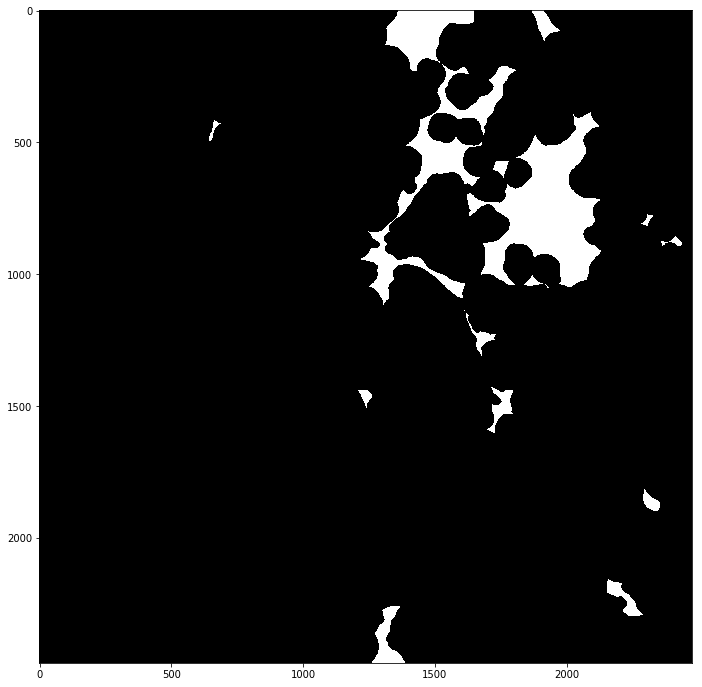

In [40]:
good_contours_med = cv2x.filter_contours_by_size(
    mode_s_med,
    min_size=2*32 * 32,
    max_size=(img.shape[0] * img.shape[1]) * .125
)

single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(single_cnt_mask, good_contours_med, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(single_cnt_mask, cmap='gray')

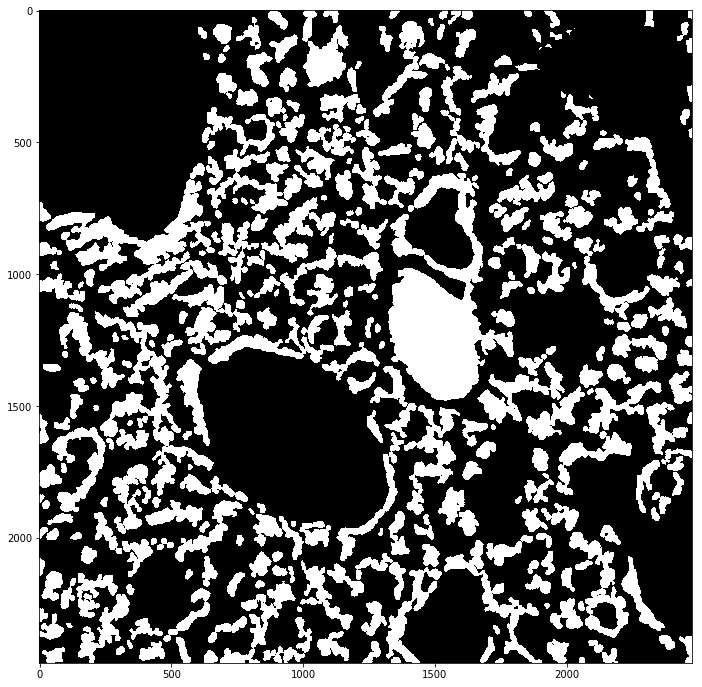

In [41]:
edge_mask = cv2.bitwise_and(edge_mask, edge_mask, mask=~final_large_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray')

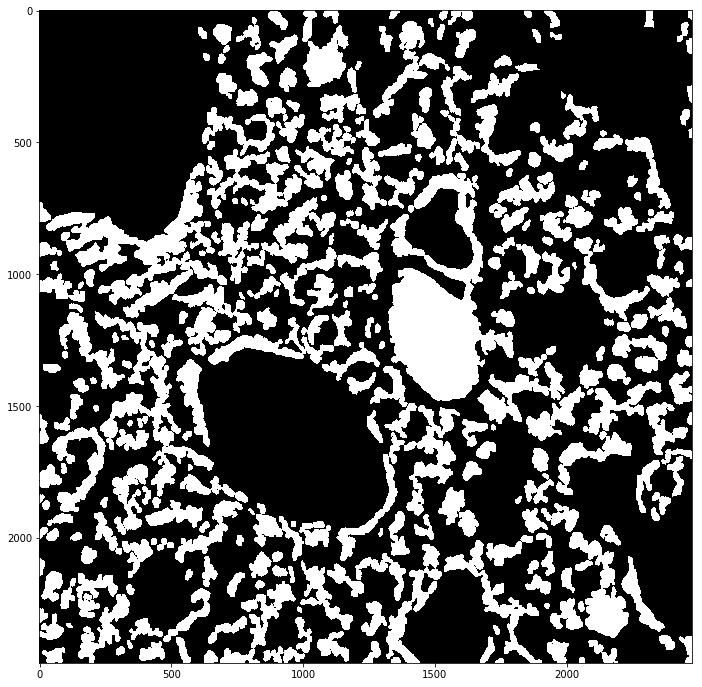

In [43]:
contours = cv2x.filter_contours_by_size(edge_mask, min_size=21*21)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, (3, 3), iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

In [45]:
final_med_sat_val_contours = []

for i, c in enumerate(good_contours_med):
    print('#', i, '#')
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = cv2x.find_border_by_mask(
        edge_mask, 
        filled_c_mask,
        max_dilate_percentage=1.5,
        dilate_iterations=1
    )
    
    print('\t', signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        final_med_sat_val_contours.append(contours[0])
    elif signal > 0.7:
        final_med_sat_val_contours.append(c)
    else:
        pass  # ignore contour

# 0 #
	 0.8347689898198903
# 1 #
	 0.8787878787878788
# 2 #
	 0.8478260869565217
# 3 #
	 0.4685908319185059
# 4 #
	 0.6374223602484472
# 5 #
	 0.8181076672104405
# 6 #
	 0.5475040257648953
# 7 #
	 0.7149643705463183
# 8 #
	 0.6020671834625323
# 9 #
	 0.484297520661157
# 10 #
	 0.8046875
# 11 #
	 0.4932807478819749
# 12 #
	 0.6007957559681698
# 13 #
	 0.5777854136242591


In [46]:
len(final_med_sat_val_contours)

6

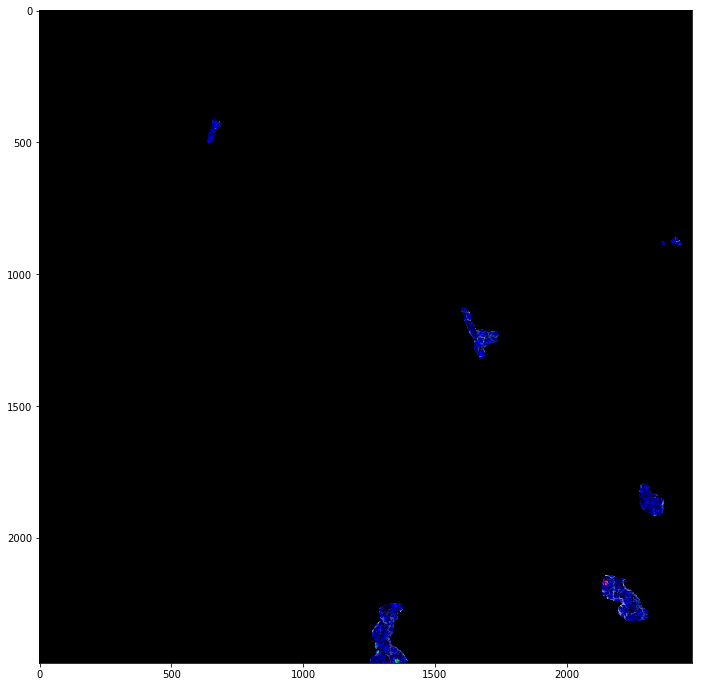

In [47]:
med_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(med_sat_val_mask, final_med_sat_val_contours, -1, 255, cv2.FILLED)

med_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(med_sat_val_img)

In [48]:
# The previous contours represent the final count of contours for the med sat-val group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next group of candidates
_, contours, _ = cv2.findContours(
    med_sat_val_mask,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

final_med_sat_val_contours = []

for c in contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.0035 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.dilate(single_cnt_mask, circle_strel, iterations=10)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    final_med_sat_val_contours.append(tmp_contours[0])

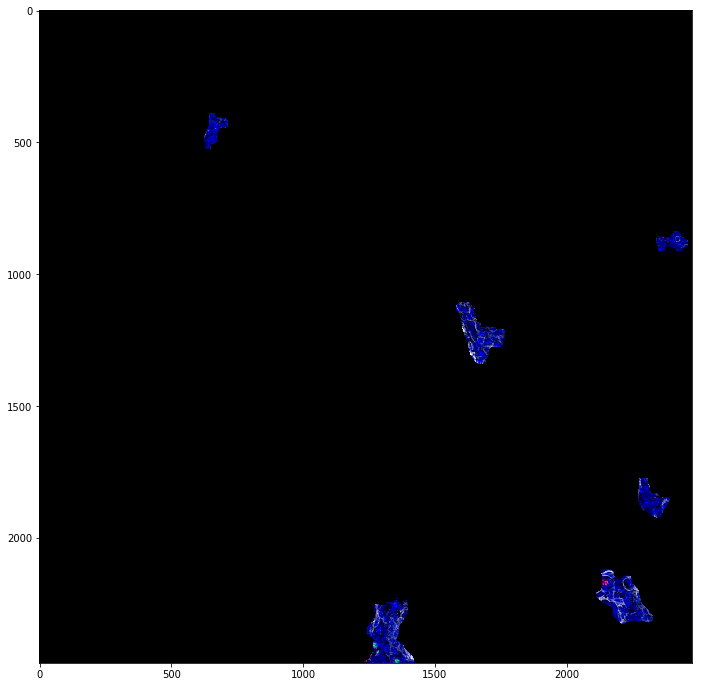

In [49]:
# final color mask to use for exclusion from further groups
final_med_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_med_sat_val_mask, final_med_sat_val_contours, -1, 255, -1)

med_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(med_sat_val_img)

#### Small sat-val candidates

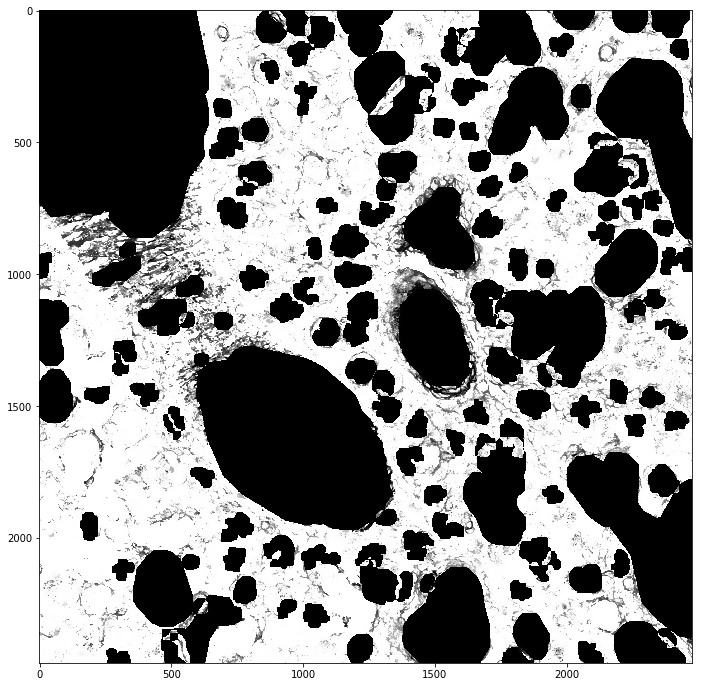

In [50]:
# start large structure saturation candidates
img_s_small_blur = cv2.bilateralFilter(img_s, small_blur_kernel[0], 31, 31)

fig = plt.figure(figsize=fig_size)
plt.imshow(img_s_small_blur, cmap='gray')

In [51]:
med = np.median(img_s_small_blur[img_s_small_blur > 0])

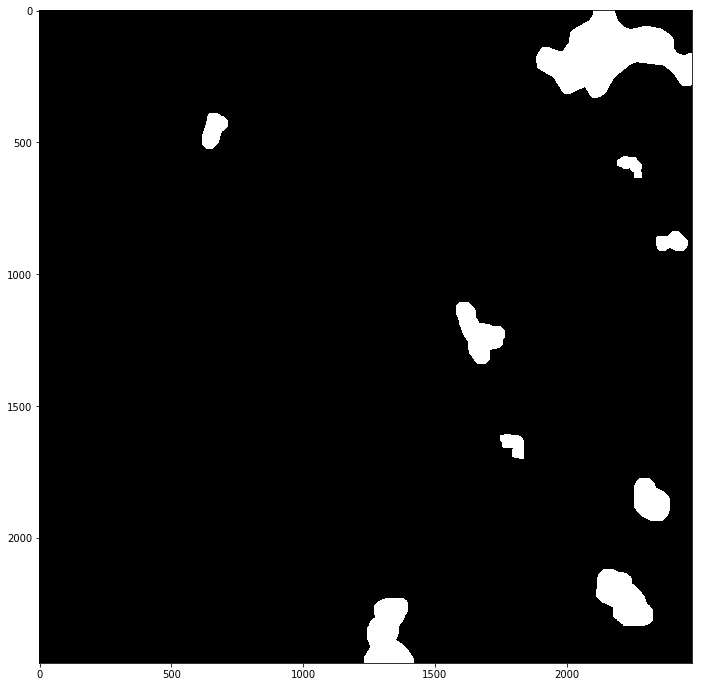

In [52]:
# make intermediate candidate mask
tmp_candidate_mask = np.bitwise_or(tmp_candidate_mask, final_med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_candidate_mask, cmap='gray')

In [53]:
img_s_small_blur = cv2.bitwise_and(img_s_small_blur, img_s_small_blur, mask=~tmp_candidate_mask)

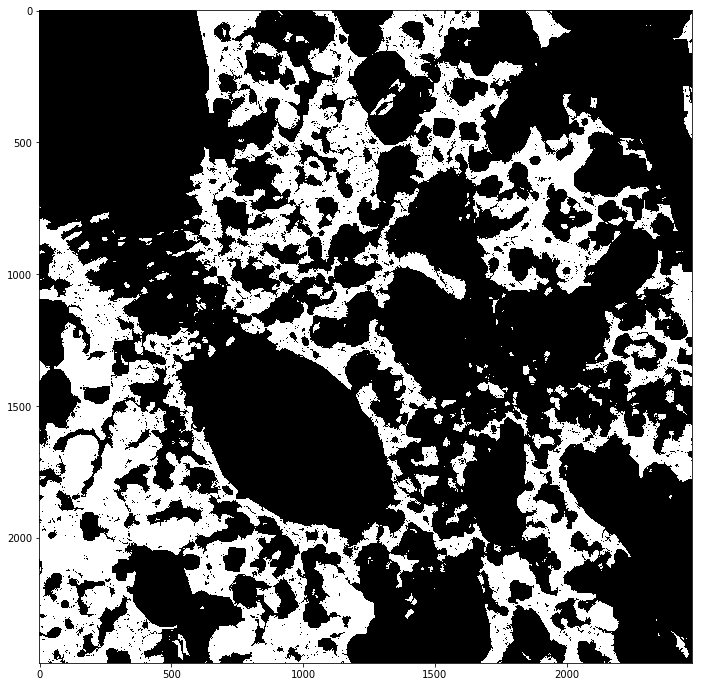

In [54]:
mode_s_small = cv2.inRange(img_s_small_blur, np.ceil(med), 255)

fig = plt.figure(figsize=fig_size)
plt.imshow(mode_s_small, cmap='gray')

In [55]:
mode_s_small = cv2.erode(mode_s_small, np.ones((3, 3)), iterations=2)

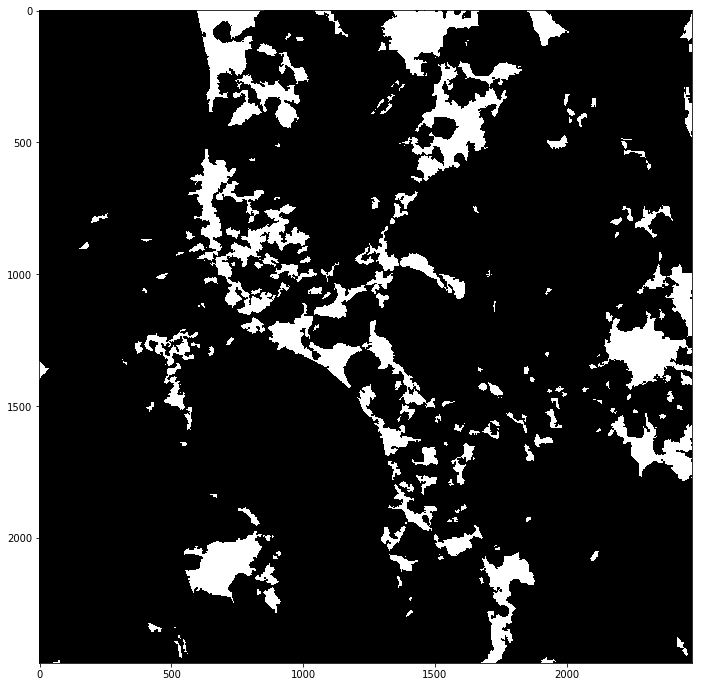

In [56]:
good_contours_small = cv2x.filter_contours_by_size(
    mode_s_small,
    min_size=17 * 17,
    max_size=(img_shape[0] * img_shape[1]) * .05
)

single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(single_cnt_mask, good_contours_small, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(single_cnt_mask, cmap='gray')

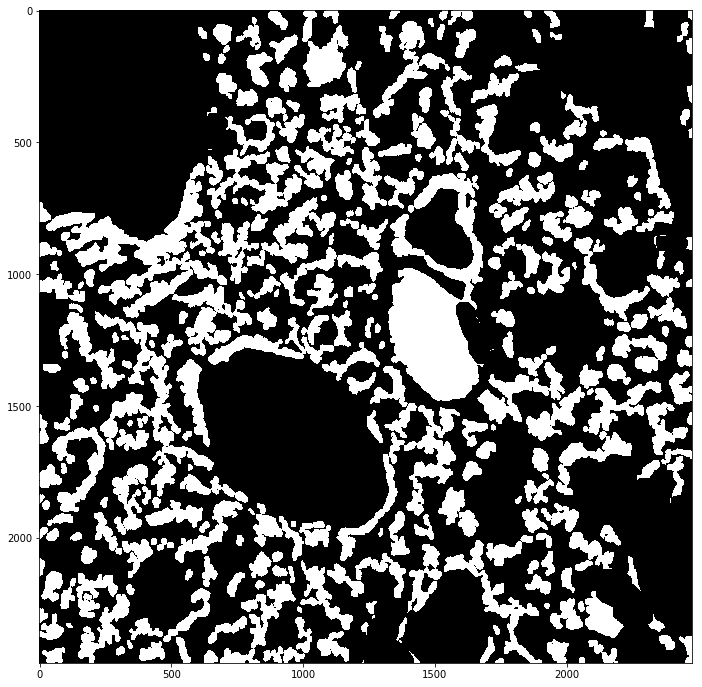

In [57]:
edge_mask = cv2.bitwise_and(edge_mask, edge_mask, mask=~final_med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray')

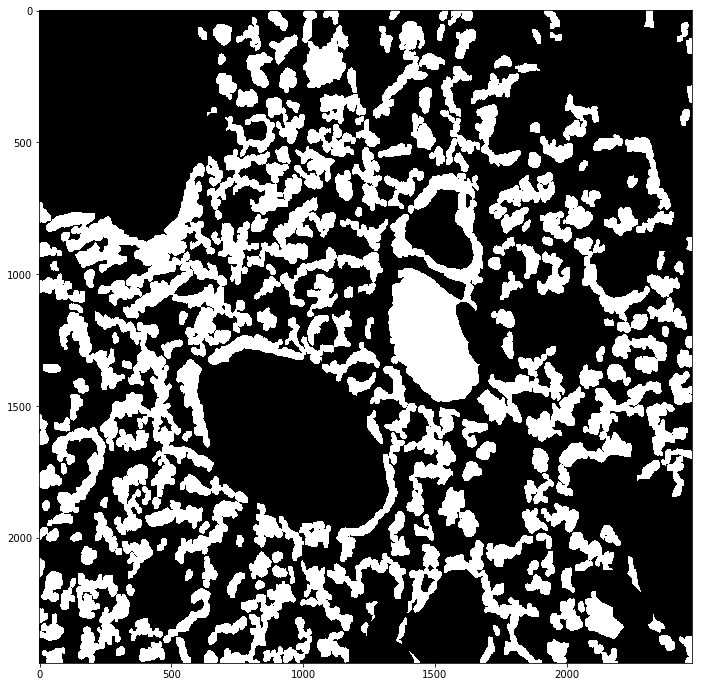

In [58]:
contours = cv2x.filter_contours_by_size(edge_mask, min_size=31*31)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, (3, 3), iterations=3)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

In [59]:
final_small_sat_val_contours = []

for i, c in enumerate(good_contours_small):
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = cv2x.find_border_by_mask(
        edge_mask, 
        filled_c_mask,
        max_dilate_percentage=2.5,
        dilate_iterations=1
    )
    
    print(i, '\t', signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        final_small_sat_val_contours.append(contours[0])
    elif signal > 0.7:
        final_small_sat_val_contours.append(c)
    else:
        pass  # ignore contour

0 	 1.0
1 	 0.5220588235294118
2 	 0.6588921282798834
3 	 0.5227686703096539
4 	 0.7348484848484849
5 	 0.5481927710843374
6 	 0.2907801418439716
7 	 0.5025125628140703
8 	 0.4583333333333333
9 	 0.7018072289156626
10 	 0.658008658008658
11 	 1.0
12 	 0.6522727272727272
13 	 0.33620689655172414
14 	 0.6196473551637279
15 	 0.7406400966183575
16 	 0.9397590361445783
17 	 0.9364161849710982
18 	 0.8439716312056738
19 	 0.5945777500779059
20 	 0.5062370062370062
21 	 0.5006821282401092
22 	 1.0
23 	 1.0
24 	 0.7387755102040816
25 	 0.5110192837465565
26 	 0.7250673854447439
27 	 0.40948275862068967
28 	 0.6075880758807588
29 	 0.2729083665338645
30 	 0.22304832713754646
31 	 0.7209944751381215
32 	 0.5619834710743802
33 	 0.6778242677824268
34 	 0.2943327239488117
35 	 0.523225241016652
36 	 0.3441295546558704
37 	 0.6944444444444444
38 	 0.46219931271477666
39 	 0.6891025641025641
40 	 0.6837209302325581
41 	 0.5584415584415584
42 	 0.35988200589970504
43 	 0.8169014084507042
44 	 0.5049

In [60]:
len(final_small_sat_val_contours)

62

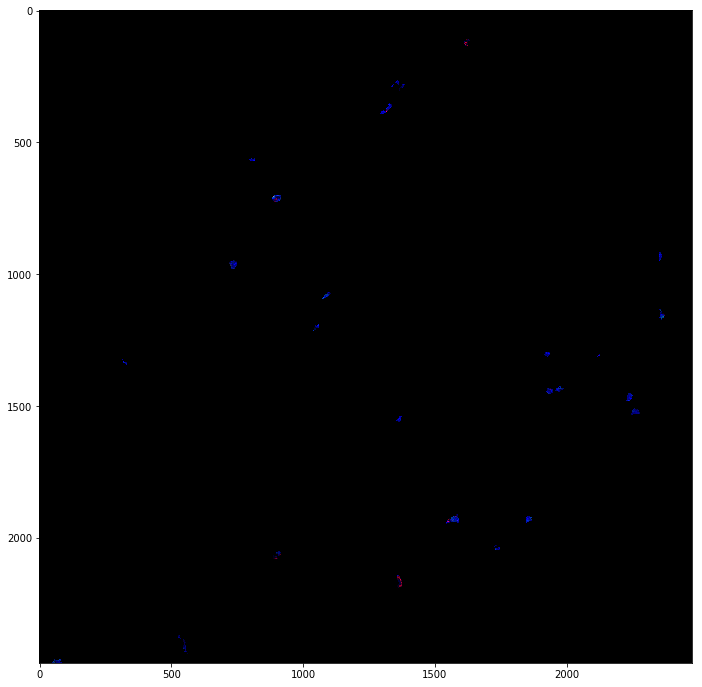

In [61]:
small_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)

tmp_small_sat_val_contours = final_small_sat_val_contours.copy()
final_small_sat_val_contours = []

for c in tmp_small_sat_val_contours:
    area = cv2.contourArea(c)
    if area <= 729:
        cv2.drawContours(small_sat_val_mask, [c], -1, 255, cv2.FILLED)
    else:
        final_small_sat_val_contours.append(c)

small_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=small_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(small_sat_val_img)

In [62]:
len(final_small_sat_val_contours)

35

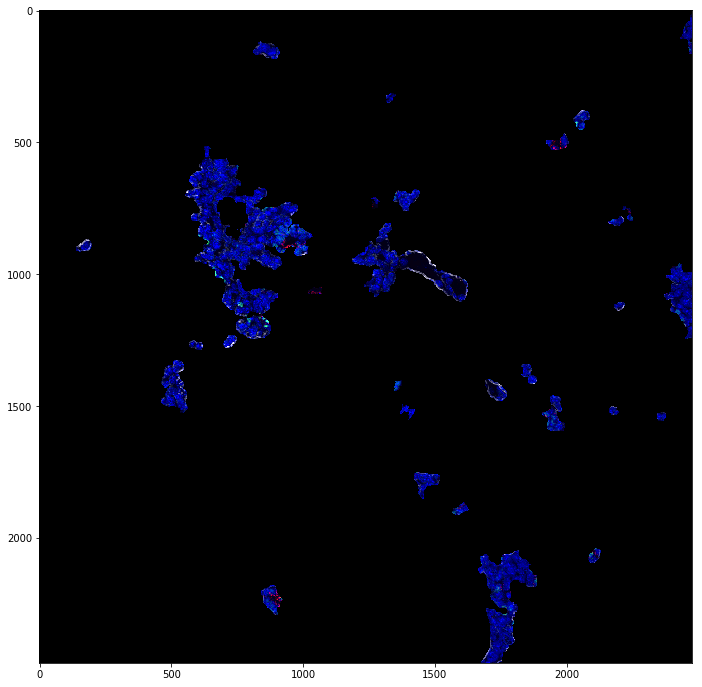

In [63]:
small_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(small_sat_val_mask, final_small_sat_val_contours, -1, 255, cv2.FILLED)

small_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=small_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(small_sat_val_img)

In [64]:
# The previous contours represent the final count of contours for the large sat-val group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next group of candidates
_, contours, _ = cv2.findContours(
    small_sat_val_mask,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

final_small_sat_val_contours = []

for c in contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.007 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.dilate(single_cnt_mask, np.ones((3, 3)), iterations=10)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    final_small_sat_val_contours.append(tmp_contours[0])

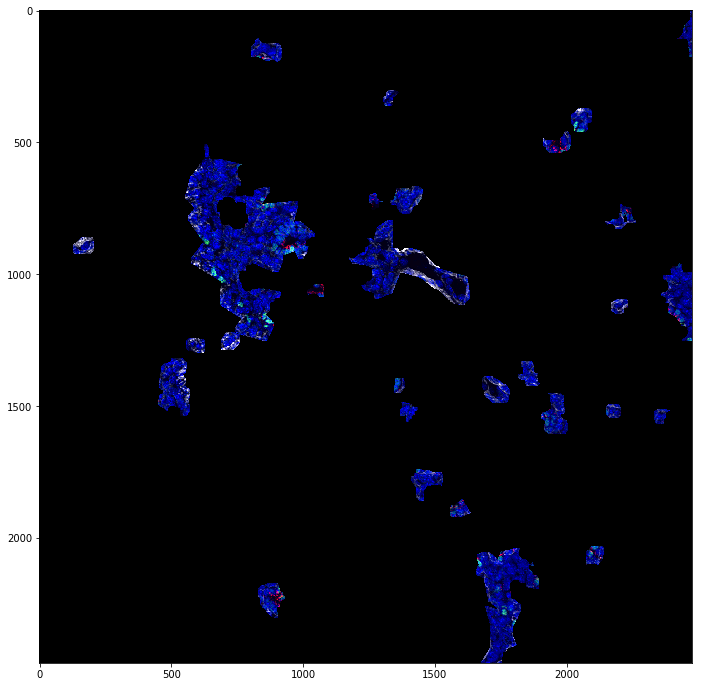

In [65]:
# final color mask to use for exclusion from further groups
final_small_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_small_sat_val_mask, final_small_sat_val_contours, -1, 255, -1)

small_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_small_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(small_sat_val_img)

## Merge all candidates

In [66]:
all_contours = final_color_contours + final_large_sat_val_contours + final_med_sat_val_contours +final_small_sat_val_contours

In [67]:
len(all_contours)

39

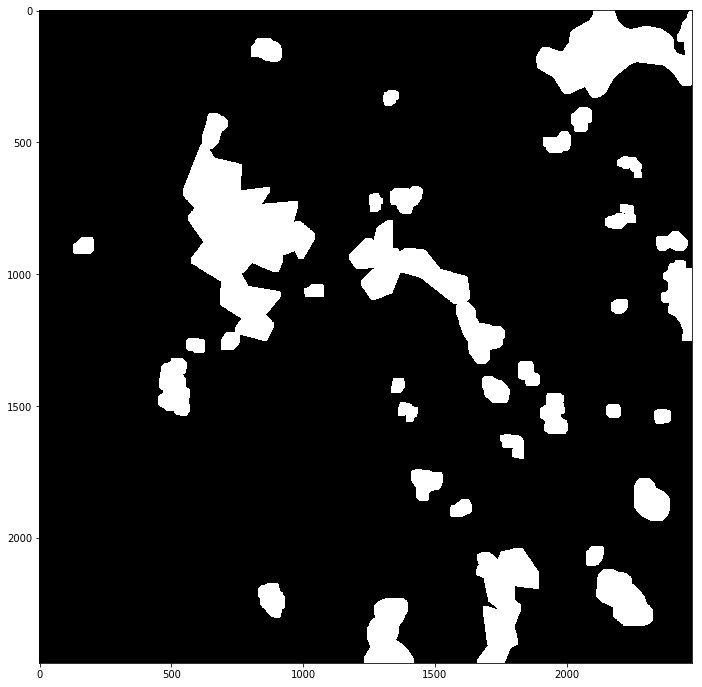

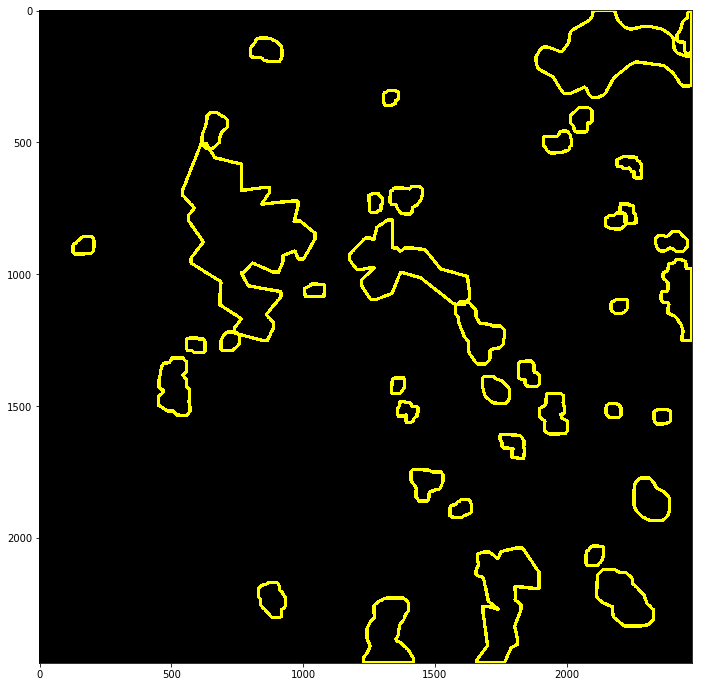

In [68]:
filled_c_mask = np.zeros(img_s.shape, dtype=np.uint8)
border_mask = np.zeros(img_rgb.shape, dtype=np.uint8)

for c in all_contours:    
    cv2.drawContours(filled_c_mask, [c], 0, 255, cv2.FILLED)
    cv2.drawContours(border_mask, [c], 0, (255, 255, 0), 11)
    
fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(filled_c_mask, cv2.COLOR_GRAY2RGB))

fig = plt.figure(figsize=fig_size)
plt.imshow(border_mask)

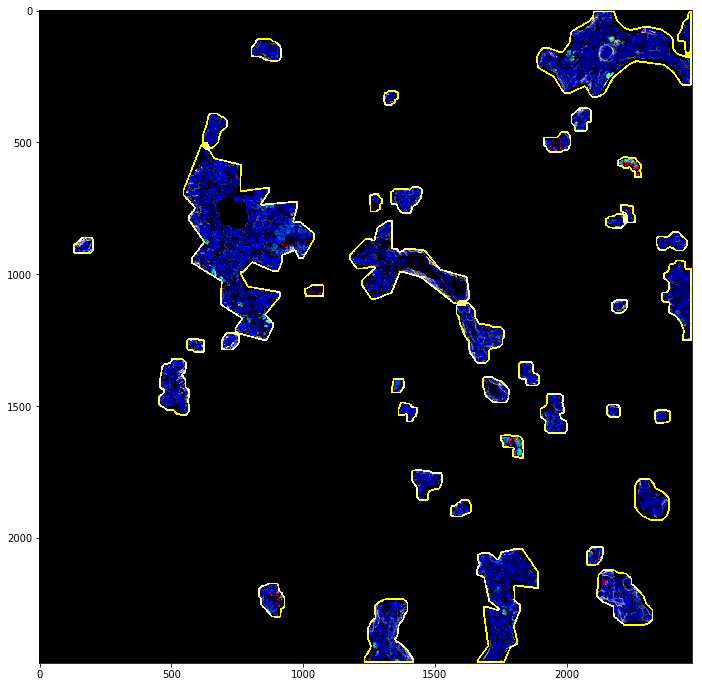

In [69]:
final_candidate_img = cv2.bitwise_or(img_rgb, border_mask, mask=filled_c_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(final_candidate_img)

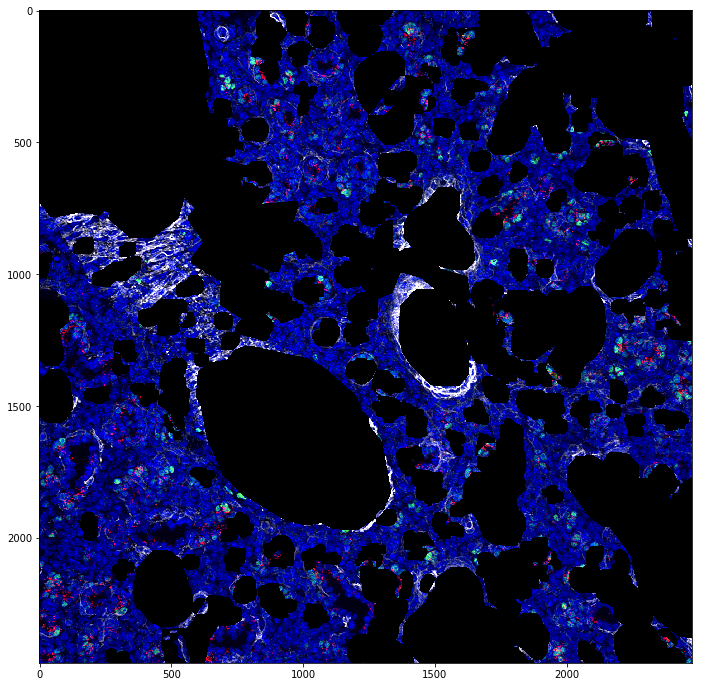

In [70]:
final_non_candidate_img = cv2.bitwise_and(img_rgb, img_rgb, mask=~filled_c_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(final_non_candidate_img)